In [ ]:
https://realpython.com/python-keras-text-classification/ #choosing-a-data-set

In [3]:
import jieba
import jieba.analyse

#from keras.models import Sequential
from keras import layers, metrics
from keras.layers import Dense, Activation, Dropout

#import tensorflow as tf
import pickle
import gensim
from gensim.models import Word2Vec

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import os
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (done)/NLP_for_onedrive')
from NLP_function import *
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (done)/NLP_for_onedrive/In_Database_cn')

# Import and transform into vector

In [5]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (done)/NLP_for_onedrive')
X,Y = read_dataset('cli.tokenizing_all_hpo.csv', index=102, lan ='cn')

# TOKENIZATION
x_cut = X.apply(lambda txt: list(jieba.cut(txt))) #调用结巴分词

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Jingz\AppData\Local\Temp\jieba.cache
Loading model cost 0.593 seconds.
Prefix dict has been built successfully.


In [ ]:
x_cut.head()

### X: Creat dictionary

In [8]:
maxlen = 200
min_count = 5 
content = []

for i in x_cut:
	content.extend(i)

## Creat Dictionary
tokenizer = pd.Series(content).value_counts()
tokenizer = tokenizer[tokenizer >= min_count]
tokenizer [:] = range(1, len(tokenizer)+1)
tokenizer [''] = 0

vocab_size = len(tokenizer.index)

## count
def doc2num(s, maxlen): 
    s = [i for i in s if i in tokenizer.index]
    s = s[:maxlen] + ['']*max(0, maxlen-len(s))
    return list(tokenizer[s])

doc2num = x_cut .apply(lambda s: doc2num(s, maxlen))

X = np.array(list(doc2num))

### Y : One-hot Encoding

In [5]:
# encode the list of cities into categorical integer values

from sklearn.preprocessing import LabelEncoder

encoder_lab = LabelEncoder()
Y_labels = encoder_lab.fit_transform(Y)
num_classes = np.max(Y_labels) + 1
print('number of sample ', Y_labels.shape[0])
print(np.max(Y_labels) + 1, 'levels')

# transform into one-hot array

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
Y_onehot = Y_labels.reshape((len(Y_labels), 1))
Y_onehot = encoder.fit_transform(Y_onehot)
print('Y_onehot shape ',Y_onehot.shape)

number of sample  672
18 levels
Y_onehot shape  (672, 18)


In [6]:
lables = pd.DataFrame({'y_id': encoder.categories_[0].tolist(), 'y_labels':encoder_lab.classes_.tolist()})
lables.head()

#lables = pd.DataFrame({'Y_labels': Y_labels, 'Y': Y})
#lables = lables.drop_duplicates().sort_values('Y_labels')
#lables.head()

,y_id,y_labels
0,0,不孕不育
1,1,多囊卵巢
2,2,女性外生殖器中个体有四六XY核型
3,3,无
4,4,无精子症


### Split data

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_onehot, test_size=0.4, random_state=10)
#print(x_train, Y_train)
print('x_train shape:', X_train.shape, 'Y_train shape:', Y_train.shape, 'X_test shape:', X_test.shape, 'Y_test shape:', Y_test.shape)

x_train shape: (403,) Y_train shape: (403, 18) X_test shape: (269,) Y_test shape: (269, 18)


#  Load pretrained embeddings

GloVe co-occurrence matrix (faster to compute), Word2Vec neural networks (more accurate)

In [ ]:
from gensim.models import Word2Vec

# train word embedding model with local data
model = Word2Vec(x_cut.tolist(),  size=300, min_count=0, workers=8, alpha=0.025)
print(model)

# save the vectors in a new matrix
embedding_matrix = np.zeros((len(model.wv.vocab) + 1, 300))
for i, vec in enumerate(model.wv.vectors):
    embedding_matrix[i] = vec

w2v = dict(zip(model.wv.index2word, model.wv.syn0)) 
print('local dictionary has',len(w2v), 'vocabularies, with dimension of 300')

#model.save('M_Word2Vec_model.bin') 
#model = Word2Vec.load('M_Word2Vec_model.bin')  # read saved model

#model.wv.most_similar_cosmul('异常') # model not good

In [ ]:
# load pretrained embedding
#os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/')

file = 'NLP_python\Embedding\Word2Vec\cn_char_fastnlp_100d.txt'
cn_model = gensim.models.KeyedVectors.load_word2vec_format(file, binary=True)
cn_model.init_sims(replace=True)


# load from google 
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)


# load Stanford’s GloVe Embedding
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.txt'
word2vec_output_file = 'word2vec.txt'
#word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
	 
    
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.txt'
word2vec_output_file = 'word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

from fastNLP.embeddings import StaticEmbedding
word2vec_embed = StaticEmbedding(tokenizer.index, model_dir_or_name='cn-char-fastnlp-100d')

In [92]:
word_vectors =  cn_model.wv
words = list(cn_model.wv.vocab)
print(words[5])
embedding_dim = cn_model['的时候'].shape
print(embedding_dim)

的时候
(100,)


C:\Users\Jingz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Jingz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
https://fastnlp.readthedocs.io/zh/latest/tutorials/tutorial_1_data_preprocess.html
https://blog.csdn.net/qq_27586341/article/details/90408342
https://www.cnblogs.com/dogecheng/p/11565530.html
    
https://blog.csdn.net/ziyonghong/article/details/83926800
https://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

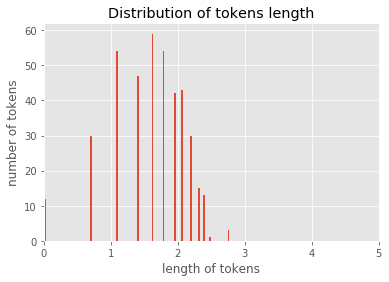

In [114]:
train_tokens = []
for text in X_train:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
# 平均tokens的长度
np.mean(num_tokens)
# 最长的评价tokens的长度
np.max(num_tokens)
plt.hist(np.log(num_tokens), bins=100)
plt.xlim((0, 5))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [117]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
 
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)
# 用来将tokens转换为文本
 
 
def reverse_tokens(tokens):
    text1 = ''
    for i in tokens:
        if i != 0:
            text1 = text1 + cn_model.index2word[i]
        else:
            text1 = text1 + ' '
    return text
 
 
reverse = reverse_tokens(train_tokens[0])
print(reverse)

睾丸体积异常左一四毫升右一七毫升


In [ ]:
cn_model.vocab['睾丸'].index

In [ ]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/')

import numpy as np
with open("NLP_python\Embedding\Word2Vec\cn_tri_fastnlp_100d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

In [ ]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/')

embedding_dim=50
embedding_matrix = create_embedding_matrix(
    'NLP_python\Embedding\Word2Vec\cn_tri_fastnlp_100d.txt',
    tokenizer.index, embedding_dim)

In [135]:
create_embedding_matrix

<function NLP_function.create_embedding_matrix(filepath, word_index, embedding_dim)>

#### GlobalMaxPool1D model

In [172]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           #weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True)) #  embeddings are additionally trained
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))  # softmax
model.add(layers.Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 50)           6300      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 18)                198       
Total params: 7,008
Trainable params: 7,008
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train,
                epochs=20,
                verbose=False, 
                validation_data=(X_test, Y_test),
                batch_size=10)
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##### prediction on individual examples

In [200]:
labels = encoder.categories_
#labels = encoder_lab.classes_

for i in range(1):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = pd.DataFrame(labels)[np.argmax(prediction)]
    print('Actual label   :', Y_test[i])
    print('Predicted label:', Y_test[i])
    print("Predicted label: ", predicted_label,"\n")

Actual label   : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted label:  0    4
Name: 4, dtype: int64 



##### prediction on all and check model metrics

In [205]:
pred_classes = model.predict_classes([X_test], verbose=0)
pred_classes = pred_classes.tolist()
print('for sample [0], predicted classe is :', pred_classes[0])

Y_test_classes = []

for i in range(len(Y_test)):
    tem = pd.DataFrame({'y_id': encoder.categories_[0], 'Y_test': Y_test[i]})
    index = tem[tem['Y_test']==1]['y_id']
    Y_test_classes.append(index.values[0])
print('for sample [0], real classe is :', Y_test_classes[0]) 

for sample [0], predicted classe is : 4
for sample [0], real classe is : 4


In [221]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test_classes, pred_classes)
print('Accuracy: %f' % accuracy)  # same 
# precision tp / (tp + fp)
precision = precision_score(Y_test_classes, pred_classes, average='weighted') # take into account for label imbalance
print('Precision_macro: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test_classes, pred_classes, average='weighted')
print('Recall_macro: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test_classes, pred_classes, average='weighted')
print('F1 score_macro: %f' % f1)

Accuracy: 0.881041
Precision_macro: 0.842492
Recall_macro: 0.881041
F1 score_macro: 0.852997


##### save model

In [34]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/NLP_for_onedrive')

# save model and architecture to single file
model.save("M_GlobalMaxPool1D.h5")
print("Saved model to disk")

Saved model to disk


### Convolutional 1D (CNN)

In [114]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, 
                           embedding_dim, 
                           input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu')) # 1D Convolutional filter
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',     # binary_crossentropy
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           10650     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 17)                187       
Total params: 44,255
Trainable params: 44,255
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9972
Testing Accuracy:  0.9950


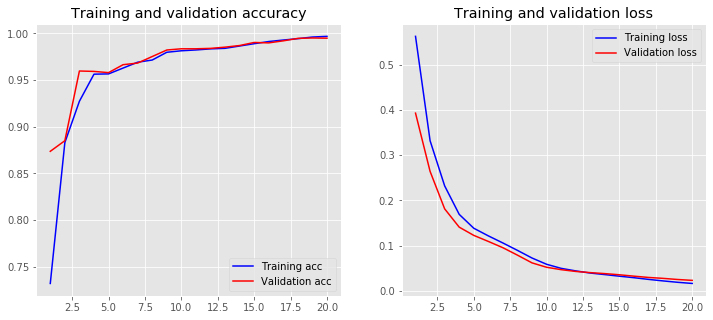

In [115]:
history = model.fit(X_train, Y_train,
                epochs=20,
                verbose=False, 
                validation_data=(X_test, Y_test),
                batch_size=10)
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##### save model

In [116]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/NLP_for_onedrive')

# save model and architecture to single file
model.save("M_Conv1D.h5")
print("Saved model to disk")

Saved model to disk


### Hyperparameters Optimization

In [13]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_model,
                        epochs=20, batch_size=10,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, Y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished


In [18]:
# Evaluate testing set
test_accuracy = grid.score(X_test, Y_test)
print(test_accuracy)

0.9949704647950524


# Prediction

In [41]:
# load model and tokenizer
loaded_model = tf.keras.models.load_model('M_GlobalMaxPool1D.h5') # or Conv1D_model.h5
print('Load model...')
model.summary()

with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

Load model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           10650     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 17)                187       
Total params: 11,347
Trainable params: 11,347
Non-trainable params: 0
_________________________________________________________________


In [ ]:
i = 10
txt = X[i]
txt = loaded_tokenizer.texts_to_sequences([txt])
txt_padded = pad_sequences(txt, padding='post', maxlen=maxlen)

pred = model.predict_classes(txt_padded)
print(X[i], 'Real class is:', Y[i])
print(X[i], 'predicted as class', pred)
print('lables :'.lables.loc[lables['Y_labels']==pred[0]])

###############################################################################

#  Train word embeddings (neural network)

### 1-Dense model

In [ ]:
# load model

from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten()) # define 
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# we have 22400 new parameters to train. This number comes from vocab_size times the embedding_dim

### 2-MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D

In the case of max pooling, take the maximum value of all features in the pool for each feature dimension. 
In the case of average pooling, take the average, but max pooling seems to be more commonly used as it highlights large values.
Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size.

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_k, Y_labels,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_k, Y_labels),
                    batch_size=10)
loss, accuracy = model.evaluate(X_k, Y_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_k, Y_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)